### Modeling

# 1. Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import gc

import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)

Unknown system...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile('/content/gdrive/MyDrive/Lpoint/LPOINT_BIG_COMP.zip', 'r') as zipObj:
    listOfFileNames = zipObj.namelist()
    for fileName in listOfFileNames:
        print(fileName)

LPOINT_BIG_COMP_01_DEMO.csv
LPOINT_BIG_COMP_02_PDDE.csv
LPOINT_BIG_COMP_03_COP_U.csv
LPOINT_BIG_COMP_04_PD_CLAC.csv
LPOINT_BIG_COMP_05_BR.csv
LPOINT_BIG_COMP_06_LPAY.csv


In [ ]:
from io import BytesIO

data_filename = []
data=[] 
with ZipFile('/content/gdrive/MyDrive/Lpoint/LPOINT_BIG_COMP.zip', 'r') as zipObj:
    listOfFileNames = zipObj.namelist()
    for fileName in listOfFileNames:
        if fileName.endswith('csv'): 
            print(fileName)
            zipRead = zipObj.read(fileName)
            curr_df = pd.read_csv(BytesIO(zipRead))
            data.append(curr_df)
            data_filename.append(fileName)

LPOINT_BIG_COMP_01_DEMO.csv
LPOINT_BIG_COMP_02_PDDE.csv


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


LPOINT_BIG_COMP_03_COP_U.csv
LPOINT_BIG_COMP_04_PD_CLAC.csv
LPOINT_BIG_COMP_05_BR.csv
LPOINT_BIG_COMP_06_LPAY.csv


In [ ]:
demo = data[0]
pdde = data[1]
cop_u = data[2]
pd_clac = data[3]
br = data[4]
lpay = data[5]

In [ ]:
lpay = data[5]

# 4. Modeling

### Bayesian Modeling

In [ ]:
pdde = pd.read_csv('/content/gdrive/MyDrive/Lpoint/pdde_1.csv')
demo = pd.read_csv('/content/gdrive/MyDrive/Lpoint/demo_최종.csv')
lpay=  pd.read_csv('/content/gdrive/MyDrive/Lpoint/lpay_1.csv')

In [ ]:
person = demo[['cust','persona']]

In [ ]:
lpay = lpay.merge(person,on = 'cust', how = 'inner')

In [ ]:
import seaborn as sns

In [ ]:
persona_list = lpay.persona.unique()

In [ ]:
mu_prior = lpay['buy_am'].mean()
std_prior =  np.log(lpay.buy_am).std()

In [ ]:
import pymc3 as pm

# 데이터를 가정한 기존 추정과는 다르게 데이터가 없는 상황에서의 추론을 이야기하는 것이다.
# 지금은 기존 데이터에 대한 상수 값이 아닌 어떤 분포를 알고있는 것이다.
price_trace_dict = dict()
increase_dict = dict()
for i in persona_list:
    sample = lpay.query('persona == @i').copy()
    lh = sample.buy_am.mean()
    with pm.Model() as model:
        lpay_sum = pm.Exponential("lpay", lam=1/mu_prior) # theta
        persona_sum = pm.Exponential("lpay_per_per", lam=1/lh)
        lpay_estimate = persona_sum
        logp = pm.Normal.dist(mu=lpay_sum, sd=(3e3)).logp(lpay_estimate)
        error = pm.Potential("error", logp) 
        trace = pm.sample(50000, step=pm.Metropolis())
        burned_trace = trace[10000:]

    price_trace = burned_trace["lpay"]
    price_trace_dict[i] = price_trace

In [ ]:
"""import pickle
# save data
with open('persona.pickle','wb') as fw:
    pickle.dump(price_trace_dict, fw)"""

### Montecarlo Simulation

In [ ]:
import pickle
with open("/content/gdrive/MyDrive/Lpoint/persona.pickle","rb") as fr:
  persona_dict = pickle.load(fr)

In [ ]:
len(persona_dict)

78

In [ ]:
import seaborn as sns

In [ ]:
def discount_rate(x,y): # 단순 매출에대한 Loss function
  if 0 < x <= 10:
    r = np.log(x) + 1
    r1 = np.random.exponential(r)
    return y*x*0.01 - y*r1*0.01 
  elif 10 < x <= 20:
    r =  np.log(x) + 2
    r1 = np.random.exponential(r)
    return y*x*0.01 - y*r1*0.01 
  else :
    return np.inf

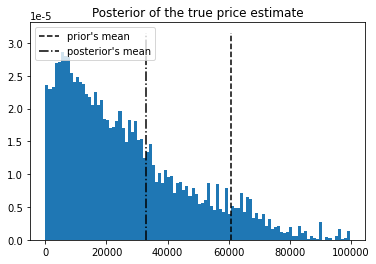

In [ ]:
# 사후분포 예시

import scipy.stats as stats
mu_prior = lpay['buy_am'].mean()
x = np.linspace(5000, 40000)
#사전에 제시한 정규분포
_hist = plt.hist(persona_dict['40대_no7_여성'], bins = 100, density= True, histtype= "stepfilled")
# 업데이트 된 후 Price_trace 의 그래프
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label = "prior's mean",
           linestyles="--")
plt.vlines(persona_dict['40대_no5_남성'].mean(), 0, 1.1*np.max(_hist[0]), \
           label = "posterior's mean", linestyles="-.")
plt.legend(loc = "upper left")

In [ ]:
print(persona_dict['40대_no7_여성'].mean(), '사후평균 예시')

In [ ]:
persona_loss= dict()
for z in persona_list:
  amount = persona_dict[z].mean()
  expected_loss = lambda discount: \
      discount_rate(discount, persona_dict[z].mean())
  a = demo.query('persona == @z')['가격민감성'].mean()
  b = demo.query('persona == @z')['광고와홍보'].mean()
  loss_list = dict()
  for i in range(1,21):
    ls = []  
    for j in range(10000):
      ls.append(expected_loss(i)*0.01  - (a+b)*np.log(i))
    loss_list[i] = np.array(ls).mean()
  key_min = min(loss_list.keys(), key=(lambda k: loss_list[k]))
  persona_loss[z] = key_min

In [ ]:
persona_dict["40대_no4_여성"].mean()

34428.256799399904

In [ ]:
key_min

3

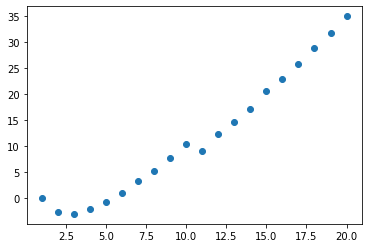

In [ ]:
plt.scatter(loss_list.keys(),loss_list.values())

In [ ]:
import pickle
with open("/content/persona_loss.pickle","wb") as fw:
  pickle.dump(persona_loss, fw)

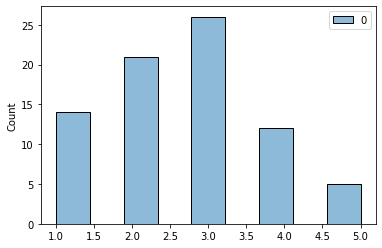

In [ ]:
sns.histplot(persona_loss.values())
plt.show()

___

In [ ]:
import pickle
with open("/content/gdrive/MyDrive/Lpoint/persona_loss.pickle","rb") as fr:
  persona_loss = pickle.load(fr)

FileNotFoundError: ignored